In [1]:
#%pip install -U -q "google-generativeai>=0.8.3"
import typing_extensions as typing
import google.generativeai as genai
from IPython.display import HTML, Markdown, display
genai.configure(api_key='')
from typing_extensions import TypedDict, List
import json
import time
from tqdm import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set a seaborn style (optional)
sns.set_theme(style="whitegrid")

# =============================================================================
# Part 1: Parsing the CSV File Using Gemini for Energy-Related Extraction
# =============================================================================

# Define the output schema for AI threat records.
class AITThreatParser(TypedDict):
    date: str
    alleged_deployer: str
    alleged_developer: str
    alleged_harmed: str
    energy_related: bool

# Instantiate the Gemini model using the above schema.
model = genai.GenerativeModel(
    'gemini-1.5-flash-latest',
    generation_config=genai.GenerationConfig(
        temperature=0.1,
        response_mime_type="application/json",
        response_schema=AITThreatParser,
    )
)

# File paths
input_csv_filepath = "datasets/incidents_aiid.csv"  # Update with your CSV file path
output_json_filepath = "aiid_output.json"

def parse_ai_threat_data(input_csv: str, output_json: str):
    try:
        df = pd.read_csv(input_csv)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return

    # Columns to be directly extracted
    deployer_col = "Alleged deployer of AI system"
    developer_col = "Alleged developer of AI system"
    harmed_col = "Alleged harmed or nearly harmed parties"
    description_col = "description"
    title_col = "title"
    
    # Fill missing values with empty strings
    for col in [deployer_col, developer_col, harmed_col, description_col, title_col]:
        if col not in df.columns:
            print(f"Warning: Column '{col}' not found in CSV!")
            df[col] = ""
        else:
            df[col] = df[col].fillna("")
            
    # Combine the text from the above columns for energy-related parsing.
    # We add labels to help the model.
    df["combined_text"] = df.apply(lambda row: (
        f"Alleged deployer of AI system: {row[deployer_col]}\n"
        f"Alleged developer of AI system: {row[developer_col]}\n"
        f"Alleged harmed or nearly harmed parties: {row[harmed_col]}\n"
        f"Description: {row[description_col]}\n"
        f"Title: {row[title_col]}"
    ), axis=1)
    
    # Ensure the "date" column exists.
    if "date" not in df.columns:
        print("Warning: 'date' column not found in CSV!")
        df["date"] = ""
    else:
        df["date"] = df["date"].fillna("")

    # Load previously processed results (if any)
    try:
        with open(output_json, 'r') as f:
            parsed_data = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        parsed_data = []

    # Use the combined text to avoid duplicate processing.
    processed_texts = {item["description"] for item in parsed_data}

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing AI Threats"):
        combined_text = row["combined_text"].strip()
        if not combined_text or combined_text in processed_texts:
            continue

        # Use the Gemini model to extract the energy_related flag.
        response = model.generate_content(combined_text)
        time.sleep(7)  # Delay to avoid rapid API calls

        try:
            parsed_item = json.loads(response.text)
            # Overwrite the returned description with our combined text (for traceability)
            parsed_item["description"] = combined_text
            # Add the date and the directly extracted fields.
            parsed_item["date"] = str(row["date"]).strip()
            parsed_item["alleged_deployer"] = row[deployer_col].strip()
            parsed_item["alleged_developer"] = row[developer_col].strip()
            parsed_item["alleged_harmed"] = row[harmed_col].strip()
            print(f"Row {idx} parsed:", parsed_item)
        except json.JSONDecodeError as e:
            print(f"Error parsing response for row {idx}: {e}")
            parsed_item = {
                "date": str(row["date"]).strip(),
                "description": combined_text,
                "alleged_deployer": row[deployer_col].strip(),
                "alleged_developer": row[developer_col].strip(),
                "alleged_harmed": row[harmed_col].strip(),
                "error": "Gemini API parsing failed"
            }
        parsed_data.append(parsed_item)
        # Save intermediate results
        with open(output_json, 'w') as f:
            json.dump(parsed_data, f, indent=4)

    print(f"Parsed data written to {output_json}")

# Uncomment the following line to run the parsing process:
#parse_ai_threat_data(input_csv_filepath, output_json_filepath)

/scratch/slurm_tmpdir/job_1502950/ipykernel_3406796/1035659848.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, fontsize=12)


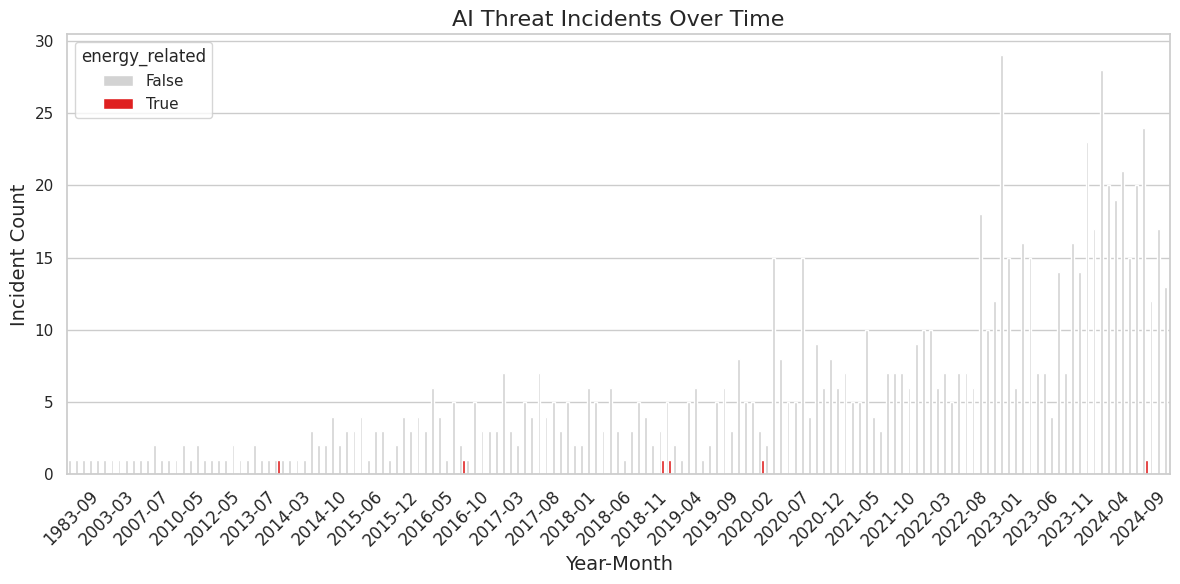

/scratch/slurm_tmpdir/job_1502950/ipykernel_3406796/1035659848.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="alleged_deployer", y="count", palette="magma")


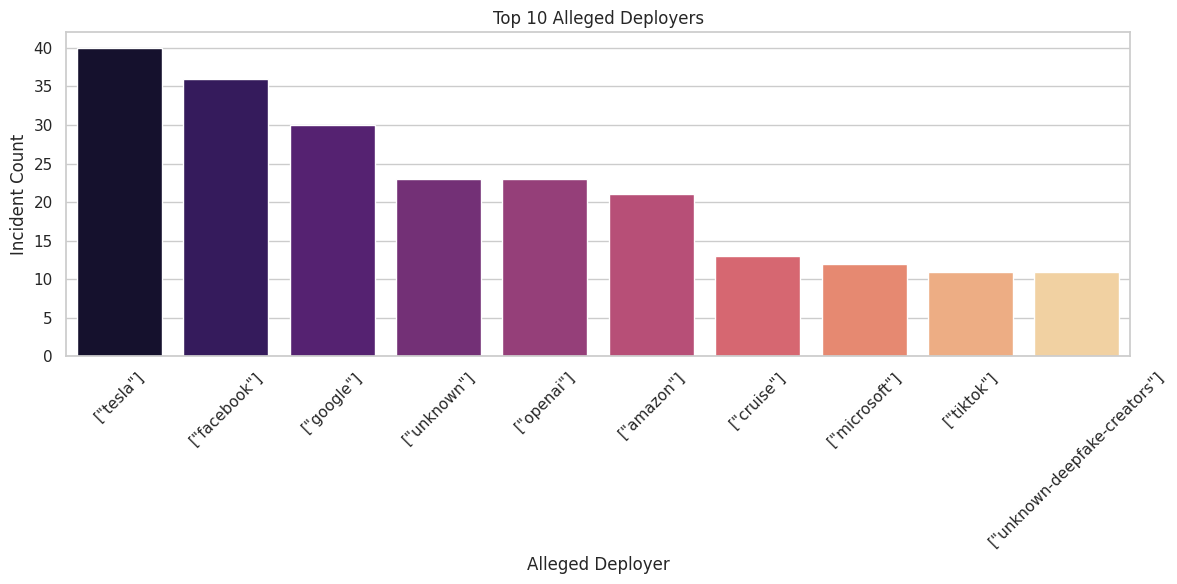

In [3]:
# =============================================================================
# Part 2: Analysis Plots Using the Parsed Data
# =============================================================================

def load_parsed_data(filepath: str):
    try:
        with open(filepath, 'r') as f:
            return json.load(f)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Error loading parsed JSON: {e}")
        return []

parsed_data = load_parsed_data(output_json_filepath)
df_parsed = pd.DataFrame(parsed_data)

# For analysis, we assume:
#  - "date" is a string that we can parse into datetime.
#  - "energy_related" is a boolean.
#  - The alleged deployer, developer, and harmed parties are available as strings.

# Convert the "date" column to datetime for time-series plotting.
df_parsed["date_parsed"] = pd.to_datetime(df_parsed["date"], errors="coerce")

def analyze_time_series(df):
    """
    Plot a time-series analysis of AI threat incidents.
    Incidents are grouped by year-month and colored based on energy-related status.
    Only every 5th x-tick label is displayed.
    """
    df_time = df.dropna(subset=["date_parsed"]).copy()
    # Group by year-month
    df_time["year_month"] = df_time["date_parsed"].dt.to_period("M")
    counts = df_time.groupby(["year_month", "energy_related"]).size().reset_index(name="count")
    counts["year_month"] = counts["year_month"].astype(str)
    
    # Use a custom palette: red for energy-related, lightgrey for non-energy-related.
    custom_palette = {False: "lightgrey", True: "red"}
    
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=counts, x="year_month", y="count", hue="energy_related", palette=custom_palette)
    plt.title("AI Threat Incidents Over Time", fontsize=16)
    plt.xlabel("Year-Month", fontsize=14)
    plt.ylabel("Incident Count", fontsize=14)
    
    # Modify x-tick labels: show only one out of every 5 labels.
    current_labels = ax.get_xticklabels()
    new_labels = [label.get_text() if i % 5 == 0 else "" for i, label in enumerate(current_labels)]
    ax.set_xticklabels(new_labels, rotation=45, fontsize=12)
    
    plt.tight_layout()
    plt.show()

# (You can add other plots as desired. For example, bar charts by alleged deployer.)

def analyze_alleged_deployer(df):
    """
    Plot the top 10 alleged deployers (directly extracted from the CSV).
    """
    df_deployer = df.copy()
    df_deployer["alleged_deployer"] = df_deployer["alleged_deployer"].fillna("").str.strip()
    counts = df_deployer["alleged_deployer"].value_counts().reset_index()
    counts.columns = ["alleged_deployer", "count"]
    top10 = counts.head(10)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top10, x="alleged_deployer", y="count", palette="magma")
    plt.title("Top 10 Alleged Deployers")
    plt.xlabel("Alleged Deployer")
    plt.ylabel("Incident Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
# Run Analyses
# -----------------------------------------------------------------------------

analyze_time_series(df_parsed)
analyze_alleged_deployer(df_parsed)

Loaded 902 records.
Preview:
                             alleged_deployer  \
0                                 ["youtube"]   
1            ["navya","keolis-north-america"]   
2                                    ["uber"]   
3  ["microsoft-research","boston-university"]   
4                     ["hospitals","doctors"]   

                                   alleged_developer  \
0                                        ["youtube"]   
1                   ["navya","keolis-north-america"]   
2                                           ["uber"]   
3  ["microsoft-research","google","boston-univers...   
4                             ["intuitive-surgical"]   

                                      alleged_harmed        date  \
0                                       ["children"]  2015-05-19   
1  ["navya","keolis-north-america","bus-passengers"]  2017-11-08   
2                  ["elaine-herzberg","pedestrians"]  2018-03-18   
3                        ["women","minority-groups"]  2016-07-21   

/scratch/slurm_tmpdir/job_1502950/ipykernel_3406796/128434325.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, fontsize=12)


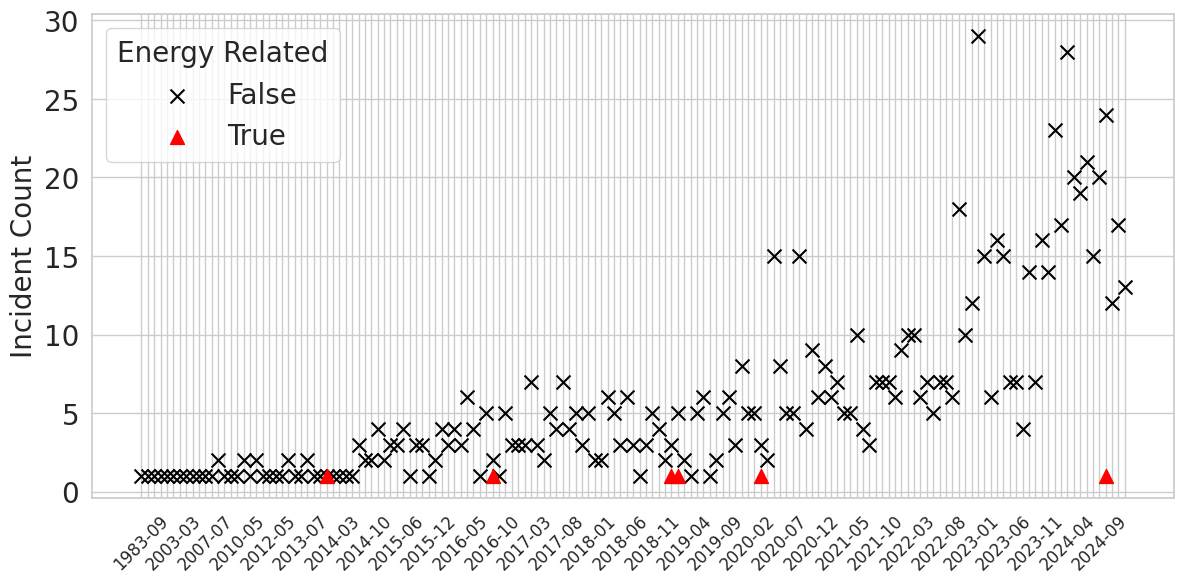

/scratch/slurm_tmpdir/job_1502950/ipykernel_3406796/128434325.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="alleged_deployer", y="count", palette="magma")


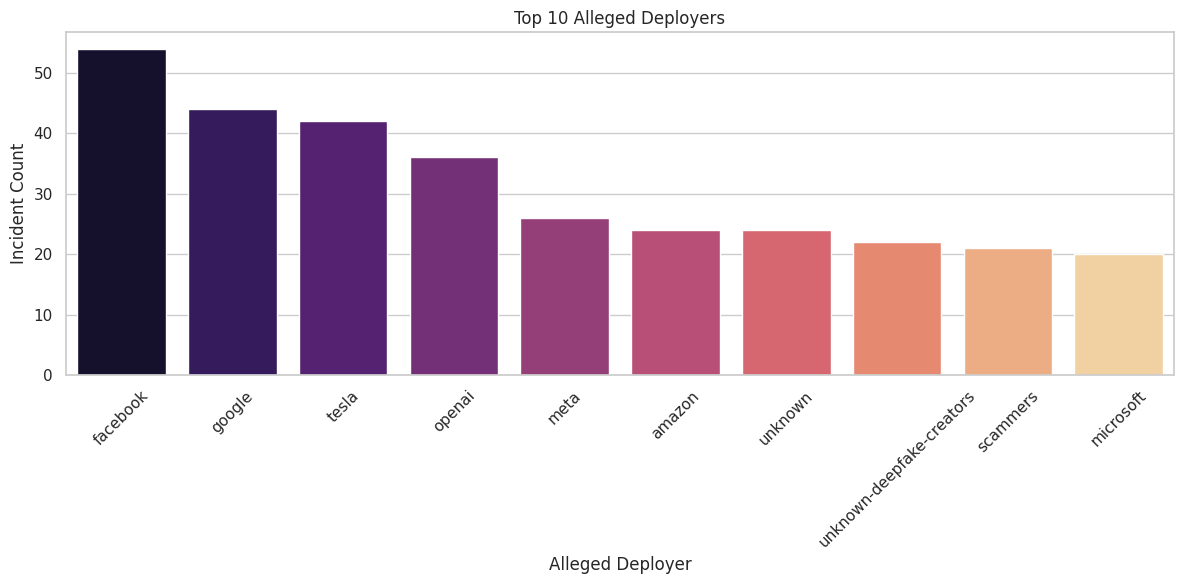

/scratch/slurm_tmpdir/job_1502950/ipykernel_3406796/128434325.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="alleged_developer", y="count", palette="coolwarm")


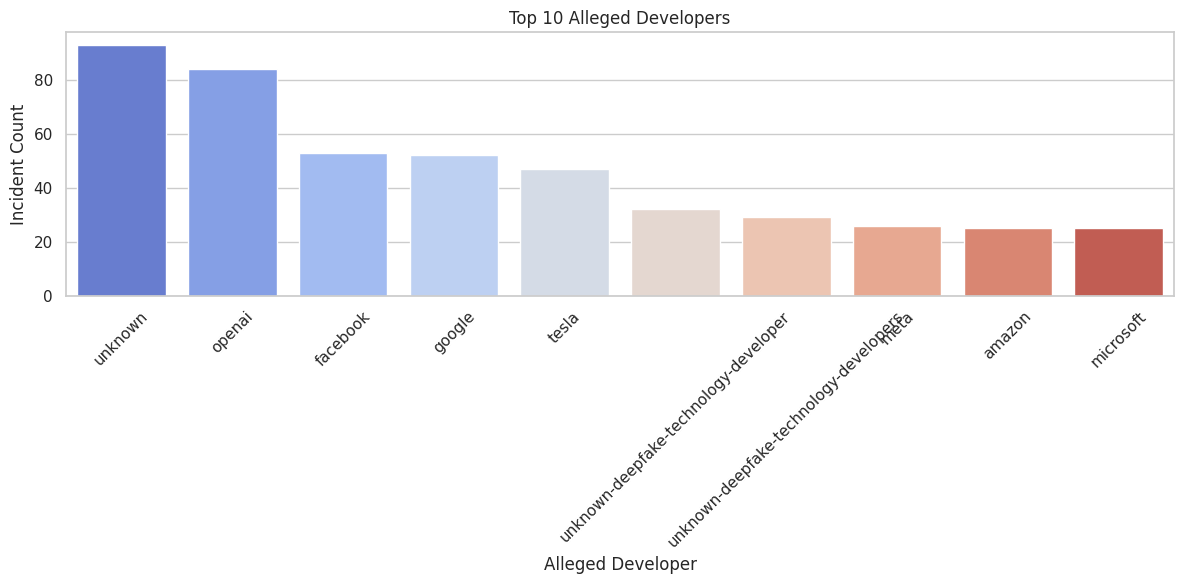

/scratch/slurm_tmpdir/job_1502950/ipykernel_3406796/128434325.py:159: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top10, y="alleged_harmed", x="count", palette="Greys", orient="h")


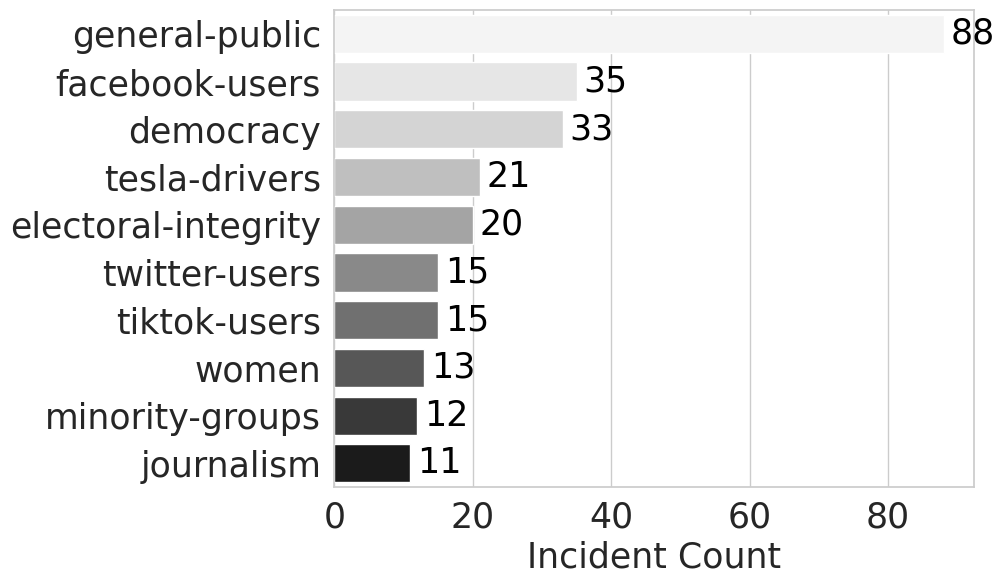

In [7]:
import ast

# -------------------------------
# Helper Functions
# -------------------------------
def parse_list_field(x):
    """
    Given a string representing a list (e.g., '["example"]'),
    try to convert it into a Python list using ast.literal_eval.
    If conversion fails, return an empty list.
    """
    if isinstance(x, str):
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list):
                # Remove any extra whitespace from each item.
                return [str(item).strip() for item in parsed if str(item).strip()]
            else:
                return []
        except Exception as e:
            print(f"Error parsing list field: {x} -> {e}")
            return []
    return []
# -------------------------------
# Load Parsed JSON Data
# -------------------------------
json_filepath = "aiid_output.json"
try:
    with open(json_filepath, 'r') as f:
        data = json.load(f)
except (FileNotFoundError, json.JSONDecodeError) as e:
    print(f"Error loading JSON data: {e}")
    data = []

# Convert loaded JSON data into a DataFrame.
df = pd.DataFrame(data)
print(f"Loaded {len(df)} records.")
print("Preview:")
print(df.head())
# -------------------------------
# Pre-Processing: Convert fields and date parsing
# -------------------------------

# Convert alleged deployer, developer, and harmed from string to actual lists.
df["alleged_deployer"] = df["alleged_deployer"].apply(parse_list_field)
df["alleged_developer"] = df["alleged_developer"].apply(parse_list_field)
df["alleged_harmed"] = df["alleged_harmed"].apply(parse_list_field)

# Convert the "date" column into datetime objects.
df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce")

# -------------------------------
# Analysis Plots
# -------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

sns.set_theme(style="whitegrid")

def analyze_time_series(df):
    """
    Plot a time-series analysis of AI threat incidents.
    Incidents are grouped by year-month.
      - Energy-related False points are plotted as black circles.
      - Energy-related True points are plotted as red triangles.
    Only every 5th x-tick label is displayed.
    """
    # Drop rows with missing dates.
    df_time = df.dropna(subset=["date_parsed"]).copy()
    # Group by year-month.
    df_time["year_month"] = df_time["date_parsed"].dt.to_period("M")
    counts = df_time.groupby(["year_month", "energy_related"]).size().reset_index(name="count")
    counts["year_month"] = counts["year_month"].astype(str)
    
    plt.figure(figsize=(12,6))
    
    # Separate groups.
    subset_false = counts[counts["energy_related"] == False]
    subset_true  = counts[counts["energy_related"] == True]
    
    # Plot using scatter: circles for False, triangles for True.
    plt.scatter(subset_false["year_month"], subset_false["count"], 
                marker='x', color="black", s=100, label="False")
    plt.scatter(subset_true["year_month"], subset_true["count"], 
                marker='^', color="red", s=100, label="True")
    
    #plt.title("AI Threat Incidents Over Time", fontsize=16)
    #plt.xlabel("Year-Month", fontsize=14)
    plt.ylabel("Incident Count", fontsize=20)
    plt.yticks(fontsize=20)
    # Create and customize the legend.
    leg = plt.legend(title="Energy Related", fontsize=20)
    leg.get_title().set_fontsize(20)  # Increase legend title font size.
    
    # Get current x-tick labels and show only every 5th.
    ax = plt.gca()
    current_labels = ax.get_xticklabels()
    new_labels = [label.get_text() if i % 5 == 0 else "" for i, label in enumerate(current_labels)]
    ax.set_xticklabels(new_labels, rotation=45, fontsize=12)
    
    plt.tight_layout()
    plt.savefig("aiid_overtime.pdf")
    plt.show()
    
# 2. Bar Plot for Alleged Deployers
def analyze_alleged_deployer(df):
    df_deployer = df.copy()
    # Explode the alleged_deployer list so each item is in its own row.
    df_deployer = df_deployer.explode("alleged_deployer")
    df_deployer["alleged_deployer"] = df_deployer["alleged_deployer"].str.strip()
    counts = df_deployer["alleged_deployer"].value_counts().reset_index()
    counts.columns = ["alleged_deployer", "count"]
    top10 = counts.head(10)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top10, x="alleged_deployer", y="count", palette="magma")
    plt.title("Top 10 Alleged Deployers")
    plt.xlabel("Alleged Deployer")
    plt.ylabel("Incident Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 3. Bar Plot for Alleged Developers
def analyze_alleged_developer(df):
    df_developer = df.copy()
    df_developer = df_developer.explode("alleged_developer")
    df_developer["alleged_developer"] = df_developer["alleged_developer"].str.strip()
    counts = df_developer["alleged_developer"].value_counts().reset_index()
    counts.columns = ["alleged_developer", "count"]
    top10 = counts.head(10)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top10, x="alleged_developer", y="count", palette="coolwarm")
    plt.title("Top 10 Alleged Developers")
    plt.xlabel("Alleged Developer")
    plt.ylabel("Incident Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 4. Bar Plot for Alleged Harmed Parties
# Set seaborn style.
sns.set_theme(style="whitegrid")

def analyze_alleged_harmed(df):
    df_harmed = df.copy()
    df_harmed = df_harmed.explode("alleged_harmed")
    df_harmed["alleged_harmed"] = df_harmed["alleged_harmed"].str.strip()
    counts = df_harmed["alleged_harmed"].value_counts().reset_index()
    counts.columns = ["alleged_harmed", "count"]
    top10 = counts.head(10)
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=top10, y="alleged_harmed", x="count", palette="Greys", orient="h")
    
    plt.xlabel("Incident Count", fontsize=25)
    plt.ylabel("", fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.tight_layout()

    # Annotate each bar with its count.
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{int(width)}', (width, p.get_y() + p.get_height()/2.),
                    ha='left', va='center', fontsize=25, color='black', xytext=(5, 0), textcoords='offset points')

    plt.savefig("harmed_parties_aiid.pdf")
    plt.show()

# -------------------------------
# Run the Analyses
# -------------------------------
analyze_time_series(df)
analyze_alleged_deployer(df)
analyze_alleged_developer(df)
analyze_alleged_harmed(df)